### Filtering Images Based on `max_detection_conf`

To refine the training data, filter out images based on the **`max_detection_conf`** value:

- **Criteria**: Exclude images from the training data if `max_detection_conf` is less than `0.900`.
- **Definition**: `max_detection_conf` represents the **maximum confidence value** among all bounding boxes provided in the `iwildcam2022_mdv4_detections.json` file.

The original train.csv containing all images was filtered and made a new file named modified.csv . modified.csv was used to fetch images .

This filtering process ensures that only images with a high confidence score are retained for training, improves the training dataset .


In [24]:
import pandas as pd
import json


# Load the CSV file
train_df = pd.read_csv('/home/guest_quest_70/UMC_Project_Group_5/vansh/train.csv')

# Load the JSON file
with open('/home/guest_quest_70/UMC_Project_Group_5/Data/iwildcam-2022/metadata/iwildcam2022_mdv4_detections.json', 'r') as f:
    json_data = json.load(f)

# Create a dictionary to map image files to their max_detection_conf
image_conf_dict = {}
for image in json_data['images']:
    image_file = image['file'].split('/')[-1]  # Get the image filename from the file path
    max_conf = image['max_detection_conf']
    image_conf_dict[image_file] = max_conf

# Filter the train_df to only include rows where max_detection_conf >= 0.900
filtered_rows = []
for _, row in train_df.iterrows():
    image_file = row['image_file']
    # Check if the image exists in the JSON and if the max_detection_conf is >= 0.900
    if image_file in image_conf_dict and image_conf_dict[image_file] >= 0.900:
        filtered_rows.append(row)

# Create a new DataFrame with the filtered rows
filtered_df = pd.DataFrame(filtered_rows)

# Save the filtered DataFrame to a new CSV file
filtered_df.to_csv('modified_train.csv', index=False)

print("Filtered CSV has been saved as 'modified_train.csv'.")


Filtered CSV has been saved as 'modified_train.csv'.


### Observing the Distribution of Image Count per Species

To analyze the dataset, observe the **distribution of image counts** for each species and identify species with a higher number of images:

- **threshold**: Filter for species with image count **greater than 2000** here .
- **Adjustable Hyperparameter**: The lower bound on the image count (e.g., 2000) is a hyperparameter and can be adjusted as needed based on specific requirements.

This approach helps in selecting species with a sufficient image count for more reliable model training.


class_label
372    12689
374    10353
96      8283
317     6887
2       4856
71      4190
90      3438
10      3356
3       3282
115     3158
380     2897
6       2484
376     2440
371     2289
24      2135
111     2083
Name: count, dtype: int64
54


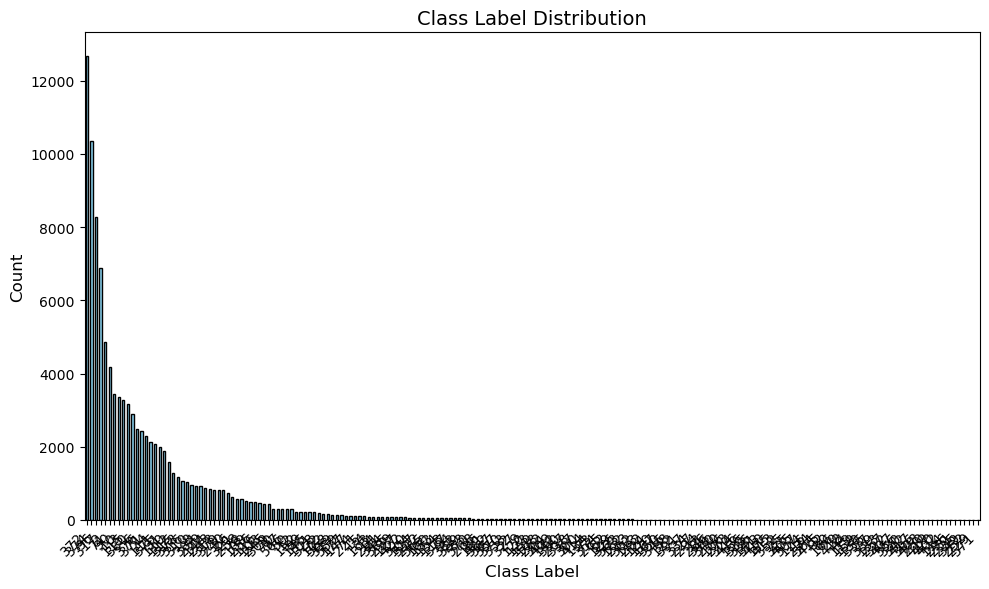

(71, 2, 100, 104, 154)

In [ ]:
import matplotlib.pyplot as plt

# Load the CSV file into a pandas DataFrame
train_df = pd.read_csv('modified_train.csv')

threshold = 2000

# Count the frequency of each class_label
class_label_counts = train_df['class_label'].value_counts()
print(class_label_counts[class_label_counts > threshold])

# Plot the distribution as a bar chart
plt.figure(figsize=(10, 6))  # Set the figure size
class_label_counts.plot(kind='bar', color='skyblue', edgecolor='black')

# Add labels and title
plt.title('Class Label Distribution', fontsize=14)
plt.xlabel('Class Label', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for readability
plt.tight_layout()  # Adjust layout to prevent clipping

# Show the plot
plt.show()


### Creating the `final(17).csv` File

After applying the filtering criteria, the `final(17).csv` file is generated. This file includes:

- **Relevant Species**: Only species with an **image count above the threshold**.
- **High Confidence Images**: Only images where **`max_detection_conf` > 0.900**.

The resulting `final(17).csv` file contains all entries meeting these conditions, ready for further processing or analysis.


In [ ]:
# Load the modified_train.csv into a pandas DataFrame
train_df = pd.read_csv('modified_train.csv')

# List of class labels to filter
class_labels_to_extract = [372, 374, 96, 317, 90, 10, 3, 115, 380, 6, 376, 371, 24, 111, 100, 104, 154]

# Filter the DataFrame based on the class_label
filtered_df = train_df[train_df['class_label'].isin(class_labels_to_extract)]

# Save the filtered DataFrame to a new CSV file
filtered_df.to_csv('final(17).csv', index=False)

print("Filtered rows saved to 'final(17).csv'.")


Filtered rows saved to 'final(17).csv'.


Since the species images count is unbalanced , we do the below to balnce it . Taking it to 4000 images each . 
Taken Images from iwildcam-2022/inaturalist_2017/Mammalia for the matching species and put the images of the species from there to populate.
Check the distribution of the species . Delete the excess and populate the necessary using augmentation .

Visualizing the final(17) . 

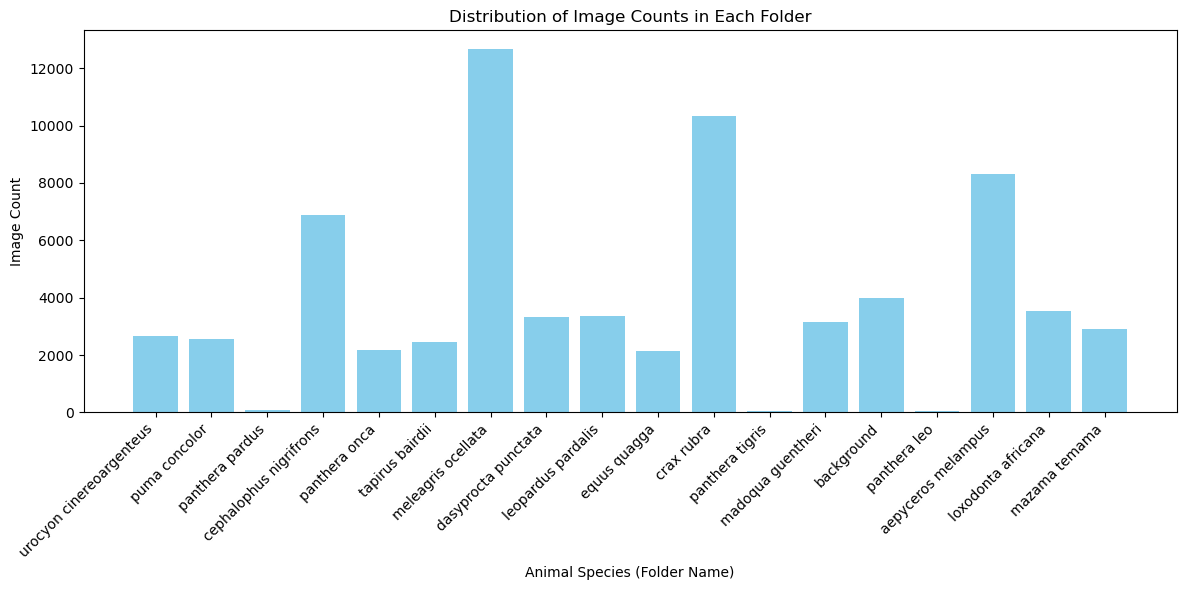

In [30]:
### Find the count of images in eqch foldr .
import os
import matplotlib.pyplot as plt

# Path to the main folder containing subfolders of animal images
base_folder = '/home/guest_quest_70/UMC_Project_Group_5/classification_dataset/train'

# Dictionary to store the count of images in each subfolder
image_counts = {}

# Loop through each subfolder and count the images
for subfolder in os.listdir(base_folder):
    subfolder_path = os.path.join(base_folder, subfolder)
    if os.path.isdir(subfolder_path):
        # Count image files in the subfolder (considering .jpg, .jpeg, and .png formats)
        image_files = [f for f in os.listdir(subfolder_path) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
        image_counts[subfolder] = len(image_files)

# Plotting the distribution
plt.figure(figsize=(12, 6))
plt.bar(image_counts.keys(), image_counts.values(), color='skyblue')
plt.xlabel('Animal Species (Folder Name)')
plt.ylabel('Image Count')
plt.title('Distribution of Image Counts in Each Folder')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Data Augmentation for Species Dataset Balancing

To achieve a balanced dataset with approximately 4000 images per species (adjustable as a hyperparameter), we applied the following augmentation techniques on images in each species folder. This was necessary to ensure all species had a sufficient number of images for robust model training.

### Augmentation Techniques Used

1. **HSV Augmentation (Hue, Saturation, and Value)**
   - Adjusts the color properties of the images, introducing variations in hue, saturation, and brightness.
   - **Purpose**: Creates diversity in color representation, helping the model learn color-invariant features.

2. **Translation Augmentation**
   - Shifts the image in horizontal or vertical directions within the frame.
   - **Purpose**: Simulates slight camera movements or changes in the animal's position, enhancing spatial robustness.

3. **Horizontal Flip**
   - Flips the image horizontally, creating a mirrored version.
   - **Purpose**: Helps the model generalize for different orientations of the animal.

### Dataset Balancing Strategy

- **Target Count**: 4000 images per species (*adjustable as needed*).
- **Existing Image Counts**: Each species folder was assessed, and augmentations were applied only to those with fewer than 4000 images.
- **Process**:
   - Images were augmented sequentially with the above techniques until the target count was reached.
   - **Randomized Augmentation**: Different augmentation parameters were randomly applied to create unique variations.

### Results

- **Augmented Species Count**: *[Specify number of species with fewer than 4000 images that received augmentation]*.
- **Final Dataset**: After augmentation, each species folder contains approximately 4000 images, creating a balanced dataset for training.

### Benefits of Augmentation

- Improves model generalization by presenting a wide variety of transformations.
- Addresses class imbalance, reducing the risk of model bias toward species with larger initial image counts.



In [ ]:
## Augmentation of images to increase the number of images .

import os
import cv2
import numpy as np
from albumentations import (
    Rotate, RandomBrightnessContrast, HueSaturationValue, ShiftScaleRotate, Perspective, HorizontalFlip
)
from albumentations.core.composition import Compose
from glob import glob
import random

# Set the minimum number of images you want in each folder
MIN_IMAGES = 4000

# Define augmentation functions using Albumentations
augmentations = Compose([
    Rotate(limit=40, p=0.5),                 # Degree rotation
    HueSaturationValue(p=0.5),               # HSV adjustment
    HorizontalFlip(p=0.5),                   # Horizontal flip
])

# Folder paths
base_folder = '/home/guest_quest_70/UMC_Project_Group_5/classification_dataset/train'

def augment_image(image):
    # Apply random augmentations
    augmented = augmentations(image=image)
    return augmented['image']

def save_augmented_images(image, species_folder, count):
    augmented_image = augment_image(image)
    cv2.imwrite(os.path.join(species_folder, f"augmented_{count}.jpg"), augmented_image)

# Process each subfolder
for species_folder in os.listdir(base_folder):
    species_path = os.path.join(base_folder, species_folder)
    if os.path.isdir(species_path):
        # Get all images in the current species folder
        image_files = glob(os.path.join(species_path, '*.jpg'))
        num_images = len(image_files)

        # Augment images if below threshold
        if num_images < MIN_IMAGES:
            print(f"Augmenting images in {species_folder}...")
            for count in range(MIN_IMAGES - num_images):
                # Randomly pick an image to augment
                image_path = random.choice(image_files)
                image = cv2.imread(image_path)
                augmented_image = augment_image(image)
                augmented_filename = os.path.join(species_path, f"augmented_{count}.jpg")
                cv2.imwrite(augmented_filename, augmented_image)

print("Image augmentation completed.")

Visualize after augmentation .

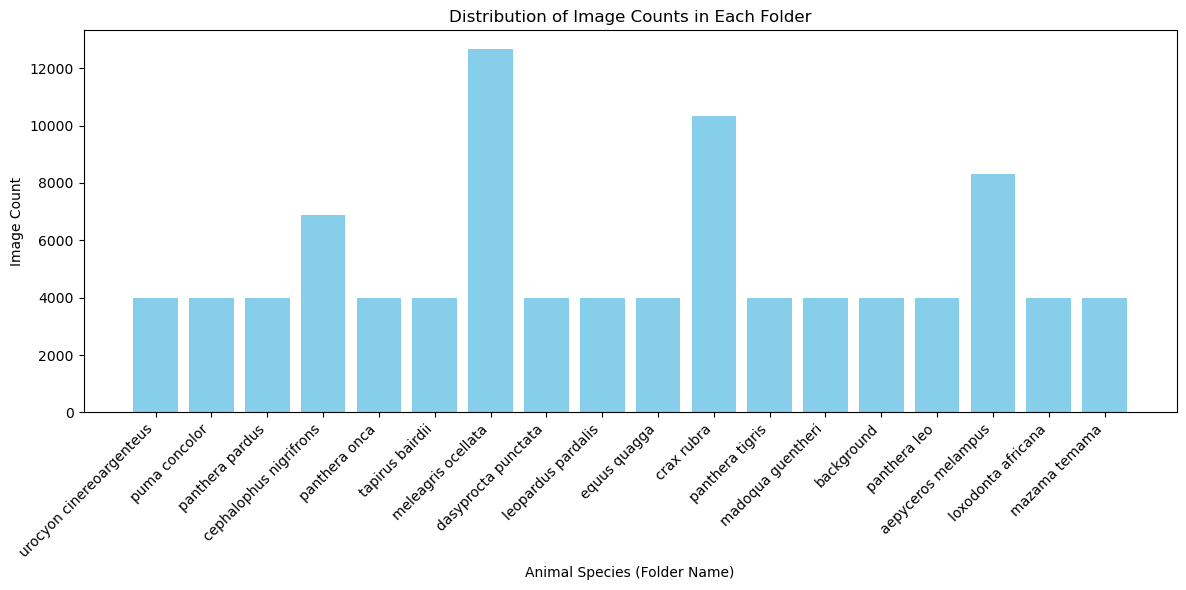

In [33]:
### Find the count of images in eqch foldr .
import os
import matplotlib.pyplot as plt

# Path to the main folder containing subfolders of animal images
base_folder = '/home/guest_quest_70/UMC_Project_Group_5/classification_dataset/train'

# Dictionary to store the count of images in each subfolder
image_counts = {}

# Loop through each subfolder and count the images
for subfolder in os.listdir(base_folder):
    subfolder_path = os.path.join(base_folder, subfolder)
    if os.path.isdir(subfolder_path):
        # Count image files in the subfolder (considering .jpg, .jpeg, and .png formats)
        image_files = [f for f in os.listdir(subfolder_path) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
        image_counts[subfolder] = len(image_files)

# Plotting the distribution
plt.figure(figsize=(12, 6))
plt.bar(image_counts.keys(), image_counts.values(), color='skyblue')
plt.xlabel('Animal Species (Folder Name)')
plt.ylabel('Image Count')
plt.title('Distribution of Image Counts in Each Folder')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

Trim the excess images (>4000(Hyperparameter)) to balance the dataset .

In [ ]:
import os
import random

# Path to the main folder containing subfolders of animal images
base_folder = '/home/guest_quest_70/UMC_Project_Group_5/classification_dataset/train'

# Set the maximum image count per folder
MAX_IMAGES = 4000

# Loop through each subfolder and handle image count
for subfolder in os.listdir(base_folder):
    subfolder_path = os.path.join(base_folder, subfolder)
    
    if os.path.isdir(subfolder_path):
        # List all image files in the subfolder (considering .jpg, .jpeg, and .png formats)
        image_files = [f for f in os.listdir(subfolder_path) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
        image_count = len(image_files)
        
        # Check if the count exceeds the max threshold
        if image_count > MAX_IMAGES:
            print(f"{subfolder} has {image_count} images, deleting excess images...")

            # Select images to delete randomly to reach the target count
            images_to_delete = random.sample(image_files, image_count - MAX_IMAGES)
            for filename in images_to_delete:
                file_path = os.path.join(subfolder_path, filename)
                os.remove(file_path)
                print(f"Deleted {file_path}")

print("Image pruning complete.")


Visualizing after trimming . Got a perfectly balanced dataset .

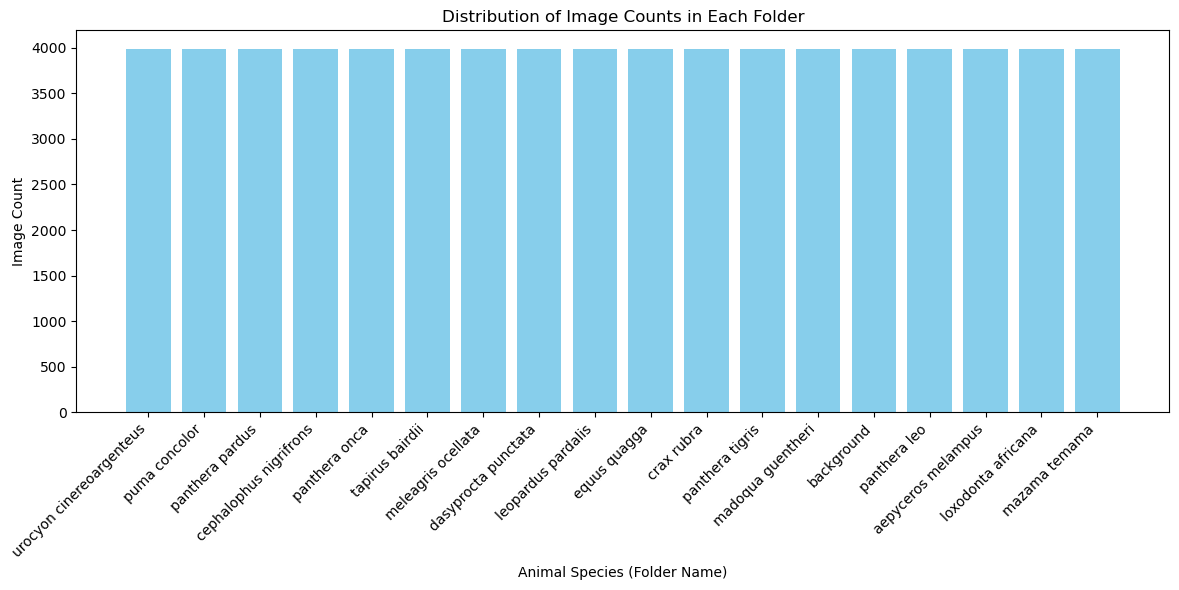

In [35]:
### Find the count of images in eqch foldr .
import os
import matplotlib.pyplot as plt

# Path to the main folder containing subfolders of animal images
base_folder = '/home/guest_quest_70/UMC_Project_Group_5/classification_dataset/train'

# Dictionary to store the count of images in each subfolder
image_counts = {}

# Loop through each subfolder and count the images
for subfolder in os.listdir(base_folder):
    subfolder_path = os.path.join(base_folder, subfolder)
    if os.path.isdir(subfolder_path):
        # Count image files in the subfolder (considering .jpg, .jpeg, and .png formats)
        image_files = [f for f in os.listdir(subfolder_path) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
        image_counts[subfolder] = len(image_files)

# Plotting the distribution
plt.figure(figsize=(12, 6))
plt.bar(image_counts.keys(), image_counts.values(), color='skyblue')
plt.xlabel('Animal Species (Folder Name)')
plt.ylabel('Image Count')
plt.title('Distribution of Image Counts in Each Folder')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()